# Trabajo Final Parte I: Trabajando con redes Encoder-Decoder

**Asignatura**: Deep Learning para procesamiento de Lenguaje Natural, 2024/2025

**Profesor**: Juan A. Botía (juanbot@um.es)

**Máster de Inteligencia Artificial**

**Facultad de Informática**

![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242)

**Universidad de Murcia**

![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png)


# Introducción

En esta práctica vamos a trabajar sobre una red del tipo sequencia-a-secuencia (sequence2sequence) basada en atención. Esta red neuronal se va a encargar de traducir del Francés al Inglés. Vamos a explicar cómo desarrollarla, su funcionamiento básico, cómo entrenarla y visualizar su comportamiento. 

Tras esto, la evaluación de la primera parte de la asignatura consistirá en la resolución de unos ejercicios sobre lo visto en la práctica.
El desarrollo de la red que hemos usado como referencia en esta práctica está basada en [este tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) de las páginas de Pytorch.  

Con la red haremos cosas como lo que sigue

``` {.sourceCode .sh}
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

\... y como se puede ver, conseguiremos unas cotas de éxito nada malas.

Ya hemos visto en clase las redes del tipo *sequence2sequence*. En las transparencias de [transformers](https://aulavirtual.um.es/access/content/group/7926_P_2024_N_N/Parte%20I%20%3A%20Deep%20Learning/ClaseTransformers.pdf) del AV hemos visto este tipo de redes, propuestas en este [paper](https://arxiv.org/abs/1409.3215). Como sabemos, el encoder de esta red convierte la secuencia de entrada en un vector de contexto que amalgama la secuencia de estados ocultos para cada token de entrada y el decoder convierte este mismo vector de contexto en una nueva secuencia. A continuación una representación esquemática de su funcionamiento.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

Ademàs, como sabemos, la [atención](https://arxiv.org/abs/1409.0473) mejora este tipo de arquitectura.

A continuación, las importaciones básicas de las librerías necesarias. Nada especial de momento.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda


In [3]:
print(torch.__version__)

2.5.1+cu121


In [4]:
print(torch.version.cuda)             # CUDA con la que fue compilado PyTorch
print(torch.cuda.is_available())      # Si la GPU está disponible
print(torch.cuda.get_device_name(0))  # Nombre de la GPU (si está disponible)

12.1
True
NVIDIA GeForce RTX 4060



# Datos de entrenamiento

Los datos de entrenamiento que vamos a usar son, como no podía ser de otra forma, datasets de pares de sentencias de los dos lenguajes que usamos en la traducción. En la página <https://www.manythings.org/anki/> tenemos ficheros de datos de muchos lenguajes al inglés. Concretamente, vamos a ver ejemplificado para el caso del inglés al francés y el fichero es [este](https://www.manythings.org/anki/fra-eng.zip). Se descargará en  `data/eng-fra.txt` y es una serie de pares

``` {.sourceCode .sh}
I am cold.    J'ai froid.
```

Para este ejemplo, se ha procesado algo y se ha vuelto a empaquetar y colocado [aquí](https://download.pytorch.org/tutorial/data.zip). Si quisiéramos usar alguno de los otros ficheros para obtener algún otro traductor, necesitaríamos previamente adaptarlo a la misma forma que este con un sencillo formateo.

Internamente, cada palabra la vamos a representar con un vector one-hot aunque reduciendo el número de palabras por lenguaje.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/word-encoding.png)

Necesitaremos un único índice para cada palabra y para llevar la cuenta de todos en cada lenguaje, usaremos una clase `Lang` que tiene sendos diccionarios `wrod2index` e `index2word` además de la longitud de cada palabra `word2count` que necesitaremos para eliminar palabras de baja frecuencia.  


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}     # Ponemos indice 0 a "SOS" e indice 1 a "EOS" en el diccionario de palabras por defecto
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Como todos los ficheros son unicode, simplificaremos las cosas pasando todo a ASCII, minúsculas, y eliminando todos los signos de puntuación.


In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    ''' Lowercase, trim, and remove non-letter characters '''

    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Como ya hemos hecho otras veces, separaremos ficheros en líneas, y las líneas en pares. Ya hemos visto que todos los ficheros contienen sentencias del inglés a otros lenguajes. Si vamos a traducir del *otro* lenguaje al inglés, simplemente ponemos `reverse` a true.


In [10]:
def readLangs(lang1, lang2, reverse=False):
    
    print("Reading lines...")

    # Read the file and split into lines (RETOCADO)
    lines = open('../data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Vamos a filtrar un poco las sentencias para hacerlo más simple y rápido, quedándonos con sentencias de 10 palabras a lo sumo y eliminando sentencias simples del tipo  \"I am\" or \"He is\" etc. 


In [11]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Entonces, el proceso global para preparar los datos incluye

* Leer el fichero de texto, separar en líneas, separar las líneas en pares

* Normalizar el texto, filtrar por longitud y contenido

* Hacer listas de palabras a partir de los pares de sentencias


In [12]:
def prepareData(lang1, lang2, reverse=False):
    ''' Esta función encapsula todos los procesos de lectura y filtrado de pares de frases y creación de diccionarios en
    los respectivos idiomas que acabamos de ver '''

    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['ils sont actuellement en reunion', 'they are currently attending a meeting']



# La red neuronal

Como hemos mencionado, vamos a usar una [Seq2Seq](https://arxiv.org/abs/1409.3215), con [encoder y decoder](https://arxiv.org/pdf/1406.1078v3.pdf) basados en redes recurrentes. 

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

¿Por qué usar dos redes recurrentes en lugar de una? El usar una segunda RNN en el decoder tiene la ventaja de desacoplar totalmente el tratamiento de la secuencia de entrada del tratamiento de la de salida. Así, ambas pueden ser tanto de diferentes diccionarios (incluso modalidades) y, naturalmente, diferentes longitudes también.

¿Qué está ocurriendo internamente? Por ejemplo, la sentencia 

 `Je ne suis pas le chat noir` → `I am not the black cat`. 
 
La mayoría de las palabras de la sentencia de entrada tienen traducción directa al inglés. Sin embargo, la traducción ideal de la setencia no vienen de la traducción de cada una de las palabras individuales. Con la red seq2seq, el encoder mediante la creación de un vector $c$ que codifica la secuencia de estados ocultos $h_1,h_2,\ldots$ es capaz, la mayoría de las veces, de codificar el *significado* de la sentencia de entrada en dicho vector, i.e., un único punto en un espacio $N$-dimensional.  
 

## El encoder

La estructura del encoder aparece en la figura de abajo. No hay nada que no hayamos visto ya. Usamos un embedding para los tokens, usamos el estado oculto anterior, en `prev_hidden`, en este caso usamos una red **GRU (Gated Recurrent Unit)** que, como ya sabemos, es una **LSTM evolucionada hacia algo más simple**:

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/encoder-network.png)

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

## El decoder

El decoder es otra GRU. Como cualquier otra GRU, acepta el estado anterior y genera el estado oculto actual. Y como cualquier otra GRU, acepta un token a la entrada y genera una salida (en este caso, dicha salida va a un softmax y de ahí al token de salida). El decoder actúa de manera iterativa. Inicial con el token `<SOS>` (start of string) y en cada iteración usa la entrada y el estado anterior para producir la salida y el estado actual.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/decoder-network.png)



In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden


## Decoder basado en atención

Ya hemos visto en las transparencias dedicadas a los [transfomers](https://aulavirtual.um.es/access/content/group/7926_P_2024_N_N/Parte%20I%20%3A%20Deep%20Learning/ClaseTransformers.pdf) cómo funciona la atención a la hora de determinar qué es lo relevante en una secuencia. Como sabemos, la atención se centra en las diferentes partes de la salida del encoder, para determinar qué es lo relevante de esa salida, y cómo de relevante. Básicamente, usamos las siguientes ideas

* Calculamos los *pesos de atención* sobre cada una de las salidas del encoder

* Esos pesos se multiplican por la salida del encoder para crear una combinación lineal, almacenada en la variable `attn_applied` 

![](https://i.imgur.com/1152PYf.png)

### Los pesos de atención

Estos se calculan mediante una capa feed-forward, en la variable `attn`, que usa la entrada al decoder y el estado oculto.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/attention-decoder-network.png)

Usamos aquí el modelo de [Bahdanau](https://arxiv.org/pdf/1409.0473.pdf), que es un modelo aditivo



In [15]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights


# Detalles sobre el entrenamiento

Para el entrenamiento, vamos a necesitar preparar los datos de training. Para cada ejemplo, necesitaremos su correspondiente tensor indexando a las palabras de la sentencia. A ambos les añadiremos un token EOS (end-of-sentence).


In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)     # Controla el entrenamiento por batches randomizados con el RandomSampler (no hace train/test por defecto)
    return input_lang, output_lang, train_dataloader


En el entrenamiento, usamos el encoder con cada setencia de entrada y llevamos la cuenta de la salida y el estado oculto correspondiente. A continuación, el decoder recibe el token `<SOS>` como primer token y el último estado oculto del encoder como su primer estado oculto. Usamos *teacher forcing* (ver traspas de Transformers de clase) de tal forma que usamos para la pérdida la respuesta real en lugar de la que sugirió el encoder. La variable `teacher_forcing_ratio` nos permitiría indicar con cuánta intensidar queremos usar teacher forcing. Pero no lo vamos a usar.


In [17]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Usamos estas funciones para imprimir el tiempo transcurrido en el entrenamiento y el estimado que nos queda, junto con el tiempo actual y su progreso.


In [18]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Una vez definido todo este código, el proceso de entrenamiento consiste en los pasos siguientes

* Lanzamos un temporizador

* Inicializamos los optimizadores y la función de pérdida

* Creamos un conjunto de pares de sentencias para el entrenamiento de la red

* Inicializamos el array de pérdida para el ploteado de su evolución

Tras esto, invocamos a `train` repetidamente y, cada cierto tiempo, imprimimos el progreso del mismo.



In [19]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


## Ploteando los resultados

Para plotear los resultados, usamos `matplotlib` ploteando el contenido de la variable `plot_losses` que hemos ido almacenando durante el entrenamiento.

In [20]:
%matplotlib inline


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    #plt.show()

# Evaluación

La evaluación que hemos definido es simplemente un registro de la predicción para la sentencia de entrada.


In [21]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Además, podemos evaluar de manera subjetiva sentencias escogidas al azar si imprimimos la entrada, lo que se debería haber traducido y la salida producida por la red, con este código.


In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


## Ejemplo de cómo entrenarla red

Una vez que tenemos todo listo -nos ha constado algún trabajo programar el código extra con todas las utilidades para el entrenamiento pero va a valer la pena porque configurar experimentos va a resultar mucho más fácil- podemos ver un ejemplo de cómo inicializar un experimento sencillo para entrenar un traductor encoder-decoder

En este ejemplo, como los datasets están muy filtrados podemos usar redes pequeñas, de 128 nodos ocultos y una única capa GRU. 


Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 11s (- 0m 11s) (1 50%) 2.4699
0m 16s (- 0m 0s) (2 100%) 1.6428


<Figure size 640x480 with 0 Axes>

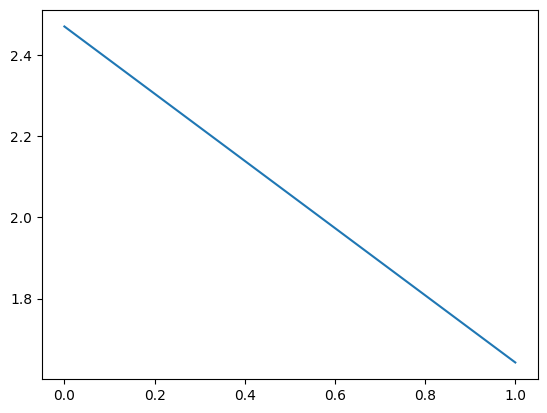

In [23]:
%matplotlib inline

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 2, print_every=1, plot_every=1)

Set dropout layers to `eval` mode


In [24]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> c est un lambin
= he s a slowpoke
< he is a good at a student <EOS>

> je finis mes devoirs
= i m finishing my homework
< i m going to be the one who trained me

> je suis diabetique
= i m a diabetic
< i m going to be <EOS>

> il devient ramollo avec l age
= he s getting soft in his old age
< he is afraid of his father <EOS>

> je suis plus intelligent que toi
= i m smarter than you
< i m glad you re the one who trained me

> il parle vite
= he is a fast speaker
< he is always a good at home <EOS>

> j ai de l interet pour la musique
= i am interested in music
< i m going to be the same <EOS>

> je suis etonnee de te voir
= i m surprised to see you
< i m sorry to have you re the one who

> je suis content que tu ailles a nouveau bien
= i m glad you re ok again
< i m glad you re the one who trained me

> il est bon chanteur
= he is a good singer
< he is afraid of the same age <EOS>




## Visualizando la atención

Una de las ventajas del mecanismo de atención es que podemos, de forma muy cómoda y sin esfuerzo adicional, interpretar en qué tokens de la entrada nos hemos basado para generar las salidas. Para eso, podemos usar `plt.matshow(attentions)` para visualizarla como una matriz a la que le añadimos ejes horizontales y verticuales para visualizarla mejor.



input = il n est pas aussi grand que son pere
output = he is not a good at the oldest <EOS>


C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


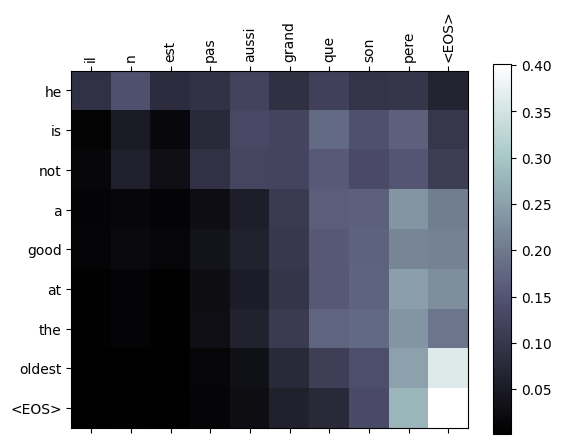

input = je suis trop fatigue pour conduire
output = i m sorry to have you for the same <EOS>


C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


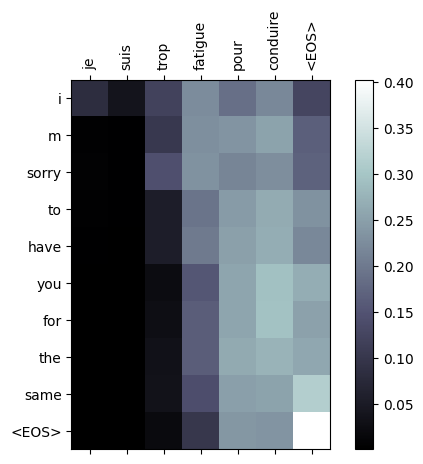

input = je suis desole si c est une question idiote
output = i m sorry for a new of the same <EOS>


C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


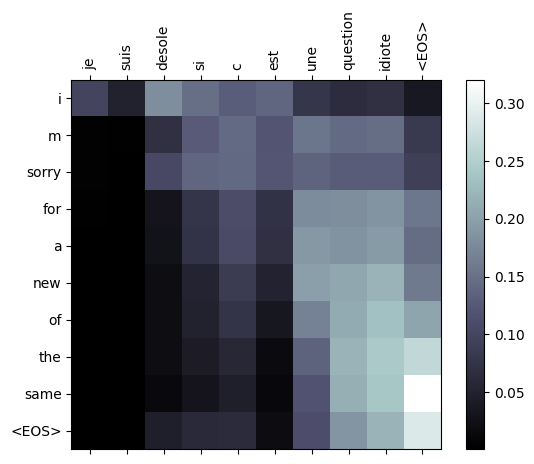

input = je suis reellement fiere de vous
output = i m sorry i didn t you <EOS>


C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Pc\AppData\Local\Temp\ipykernel_14040\1690937169.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


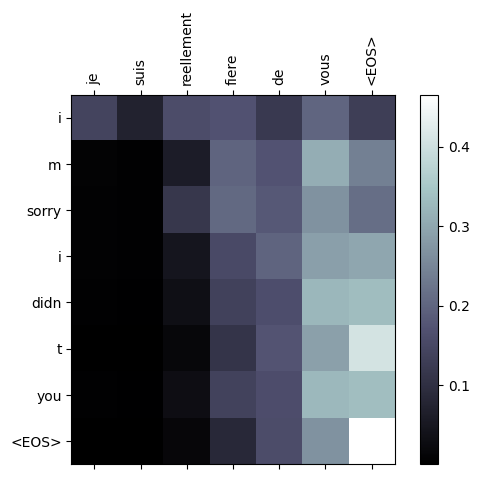

In [26]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

# Ejercicios a resolver

Se han de resolver los siguientes ejercicios. El trabajo a entregar debe consistir en un jupyter notebook en el que se incluya, para cada ejercicio, la pregunta correspondiente y la respuesta a evaluar por el profesor. Si la respuesta incluye código, este ha de estar ejecutado el mismo notebook tanto como sea posible. Excepciones a este requerimiento son los modelos producidos en el cluster, siempre que el propio notebook no se ejecute también el mismop cluster, junto con la producción del modelo.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 1:  (2 puntos)</strong></div>

Explica en detalle cómo funciona el modelo de Bahdanau, sobre la implementación que se ha usado en esta práctica y usando como apoyo el paper que se ha referenciado. Si se considera conveniente, usa el propio ejecuciones parciales (i.e. fragmentos) del propio código para proporcionar dichas explicaciones. Referencia también el mecanismo de visualización que se ha usado para los cuatro ejemplos que acabas de ver basados en las matrices de atención.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 2:  (2 puntos)</strong></div>

Haz uso del cluster para producir modelos modelos de traducción de inglés a francés. Construye un modelo de traducción basado en seq2seq sin atención. Construye otro modelo de traducción  basado en seq2seq con atención según el modelo de Bahdanau. Usa para ambos tamaños de 256 nodos y 1 capa oculta y entrena las redes durante 100 épocas. Compara los resultados. En la resolución del ejercicio incluye la especificación del trabajo SLURM, el script en Python completo para su ejecución en el cluster y el análisis de los resultados.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 3:  (3 puntos)</strong></div>

Usando los datasets de la página de [Anki](https://www.manythings.org/anki/), repetir los experimentos para crear traductores con atención de Bahdanau, del italiano al inglés y del castellano al inglés. Haz uso del cluster para producir los modelos. En la resolución del ejercicio incluye la especificación del trabajo SLURM, el script en Python completo para su ejecución en el cluster y el análisis de los resultados.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 4:  (hasta 3 puntos)</strong></div>

Tomando como referencia la arquitectura encoder-decoder que hemos usado y el modelo de atención de Bahdanau, trabaja por tu cuenta en un problema equivalente al de traducción, en el que sea posible aplicar un modelo seq2seq como el que estamos usando. Debes elegir trabajar bien en *Resumen de textos* (3 puntos) bien en *Corrección de errores* (1.5 puntos). Ejemplos de datasets que puedes usar directamente para el primero son los siguientes

<https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail>

<https://www.kaggle.com/datasets/thedevastator/pubmed-article-summarization-dataset>

<https://huggingface.co/datasets/ccdv/arxiv-summarization>

<https://huggingface.co/datasets/ccdv/pubmed-summarization>

y para el segundo 

<https://www.kaggle.com/datasets/satishgunjal/grammar-correction>

<https://huggingface.co/datasets/jhu-clsp/jfleg>

<https://huggingface.co/datasets/vishnun/SpellGram>

Elige el problema, elige el dataset, justifica tu decisión. En el caso de trabajar en resumen de textos, redimensiona el dataset para que esté entre por ecima de las 400MB y no supere las 512MB de tamaño eliminando ejemplos hasta dejar el dataset por debajo de ese tamaño. En ambos casos construye un modelo y visualiza los resultados siguiendo las pautas de ejercicios 2 y 3. Añade cualquier elemento adicional que consideres necesario. En la resolución del ejercicio incluye la especificación del trabajo SLURM, el script en Python completo para su ejecución en el cluster y el análisis de los resultados.

La fecha de entrega es el 15 de noviembre a las 23:55 mediante la correspondiente tarea que se hará disponible en el AV.

Puedes entregar cada ejercicio en un notebook separado si te resulta más cómodo. Ya se man mecionado arriba pero se reiterea. Para aquellos ejercicios que requieran del cluster, el notebook ha de entregarse ejecutado en una de dos modalidades:

* Modalidad A: todo el ejercicio en un notebook jupyter ejecutado desde un trabajo. En este caso, el notebook se habrá compilado según el comando `jupyter nbconvert --execute` tal y como hemos visto en la documentación de uso del cluster. Se hará entrega de cada notebook en la entrega de la tarea.

* Modalidad B: todo el ejercicio en un notebook jupyter, ejecutado desde un ordenador personal. La parte relativa a la generación del modelo se habrá realizado en el cluster y almacenado en un fichero que se leerá desde el notebook y se usará ya entrenado. 

Nota: se permite realizar la totalidad o parte de los ejercicios sin hacer uso del cluster. En ese caso, la nota máxima del ejercicio será la mitad de la puntuación original. 

La tarea constará de UNA ÚNICA ENTREGA que incluirá los notebooks de todos los ejercicios realizados.
